75750


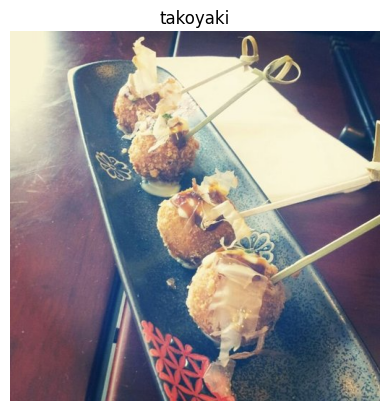

In [1]:
import torch
from torch import nn
from torchvision.datasets import Food101
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt
RAND_SEED = 2697

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Make every image be the same shape - 512 x 512
transform = Compose([Resize((512,512)),
                     ToTensor()])

train_data = Food101(root="./data/Food101/",
                     split="train",
                     download=True,
                     transform=transform,
                     target_transform=None)
test_data = Food101(root="./data/Food101/",
                     split="test",
                     download=True,
                     transform=transform,
                     target_transform=None)

# Get class list
classes = train_data.classes

# Check data
i = torch.randint(len(train_data),(1,))
print(len(train_data))
# Change the shape to be color channels last so matplotlib can show image
img = train_data[i][0].permute(1,2,0)
label = classes[train_data[i][1]]
plt.imshow(img)
plt.title(label)
plt.axis(False);

In [2]:
# Load the data sets into a DataLoader with batch size 32
from torch.utils.data import DataLoader

BS = 32

train_dl = DataLoader(dataset=train_data,
                      batch_size=BS,
                      shuffle=True)

test_dl = DataLoader(dataset=test_data,
                      batch_size=BS,
                      shuffle=True)


In [3]:
from helper_functions import accuracy_fn
# Construct a CNN to classify these images

class Food101CNN(nn.Module):
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*128*128,
                      out_features=out_shape))
        
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Instantiate our model, create a loss function and an optimizer
model1 = Food101CNN(in_shape=3, hidden_units=10, out_shape=len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model1.parameters(), lr=0.1)


In [4]:
# Find out what shape the final layer must be for the classification step in the model

dummy_image = next(iter(train_dl))[0]
dummy_image.to(device)


tensor([[[[0.4980, 0.5020, 0.5137,  ..., 0.5569, 0.5647, 0.5686],
          [0.4980, 0.5020, 0.5137,  ..., 0.5451, 0.5529, 0.5569],
          [0.5020, 0.5059, 0.5176,  ..., 0.5373, 0.5412, 0.5451],
          ...,
          [0.4941, 0.4980, 0.5020,  ..., 0.6431, 0.6431, 0.6431],
          [0.4863, 0.4902, 0.4902,  ..., 0.6431, 0.6431, 0.6431],
          [0.4784, 0.4824, 0.4824,  ..., 0.6392, 0.6353, 0.6314]],

         [[0.5333, 0.5373, 0.5490,  ..., 0.5647, 0.5725, 0.5765],
          [0.5333, 0.5373, 0.5490,  ..., 0.5529, 0.5608, 0.5647],
          [0.5294, 0.5333, 0.5451,  ..., 0.5451, 0.5490, 0.5529],
          ...,
          [0.5294, 0.5333, 0.5373,  ..., 0.6980, 0.6980, 0.6980],
          [0.5216, 0.5255, 0.5255,  ..., 0.6980, 0.6980, 0.6980],
          [0.5137, 0.5176, 0.5176,  ..., 0.7020, 0.7020, 0.6980]],

         [[0.6000, 0.6039, 0.6157,  ..., 0.6196, 0.6314, 0.6353],
          [0.6000, 0.6039, 0.6157,  ..., 0.6078, 0.6196, 0.6235],
          [0.6000, 0.6039, 0.6157,  ..., 0

In [5]:
!nvidia-smi

Mon Sep  4 10:17:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        On  | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P0              14W /  50W |    279MiB /  4096MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Build training and testing functions
def train_step(model: nn.Module,
               data: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in data:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, pred.argmax(dim=1)) # .argmax(dim=1) goes from logits to predicted index
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data)
    train_acc /= len(data)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

def test_step(model: nn.Module,
              data: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += accuracy_fn(y, pred.argmax(dim=1))
        test_loss /= len(data)
        test_acc /= len(data)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

In [7]:
from timeit import default_timer as timer
from helper_functions import print_train_time, accuracy_fn
from tqdm.auto import tqdm

epochs = 1
start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_step(model=model1,
              data=train_dl,
              loss_fn=loss_fn,
              optimizer=optim,
              accuracy_fn=accuracy_fn,
              device=device
              )
    test_step(model=model1,
              data=test_dl,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
end_time = timer()
total_train_time = print_train_time(start=start_time, end=end_time,device=device)


/home/chunt/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
-----------
Train Loss: 1988.46143 | Train Acc: 0.98%


100%|██████████| 1/1 [14:29<00:00, 869.12s/it]

Test Loss: 2529.33936 | Test Acc: 0.99%

Train time on cuda: 869.119 seconds
